---
## **Análise de Dados** | Consumo de energia elétrica no Brasil
---

### **TLDR**

 - **Dashboard**:
  - Google Data Studio ([link](https://lookerstudio.google.com/reporting/09557b36-6c5f-44e4-99e0-da6da2d4acbf)).
 - **Processamento**:
  - Kaggle Notebook ([link](https://www.kaggle.com/code/theu011/consumo-de-energia-el-trica-no-brasil)).
 - **Fontes**:
  - Ministério de Minas e Energia (MME) ([link](https://basedosdados.org/dataset/3e31e540-81ba-4665-9e72-3f81c176adad?table=b955feef-1649-428b-ba46-bc891d2facc2));

  Consumo de energia elétrica em nível nacional e segmentado pelas classes residencial, industrial, comercial e outros (rural, serviço público e iluminação pública).

  **Cobertura temporal:** 01-2004 a 12-2023

  ---

**Pacotes e bibliotecas**

In [235]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [236]:
data = pd.read_csv('consumo_energia_eletrica_uf.csv', sep=',')

In [237]:
data.head()

,ano,mes,sigla_uf,tipo_consumo,numero_consumidores,consumo
0,2004,1,TO,Total,NaN,65876
1,2004,1,BA,Total,NaN,1444451
2,2004,1,PR,Total,NaN,1596274
3,2004,1,RS,Total,NaN,1780912
4,2004,1,GO,Total,NaN,630624


Uso `data.query` para selecionar somente os tipos de consumo desejado.

In [238]:
data = data.query('tipo_consumo in ["Residencial", "Comercial", "Industrial", "Outros"]').reset_index(drop=True)

- Como cada tipo de consumo não possui uma coluna própria, separo cada tipo de consumo em um DataFrame individual.
- `sort_values()` é utilizado porque a coluna **sigla_uf** não está ordenada, então organizo os dados pela data e posteriormente, pela sigla do estado.
- Por último, removo a coluna que não é mais de interesse.

In [239]:
data_outros =  data.query('tipo_consumo == "Outros"').sort_values(by=['ano', 'mes', 'sigla_uf']).reset_index(drop=True).drop(columns='tipo_consumo')
data_residencial =  data.query('tipo_consumo == "Residencial"').sort_values(by=['ano', 'mes', 'sigla_uf']).reset_index(drop=True).drop(columns='tipo_consumo')
data_comercial =  data.query('tipo_consumo == "Comercial"').sort_values(by=['ano', 'mes', 'sigla_uf']).reset_index(drop=True).drop(columns='tipo_consumo')
data_industrial =  data.query('tipo_consumo == "Industrial"').sort_values(by=['ano', 'mes', 'sigla_uf']).reset_index(drop=True).drop(columns='tipo_consumo')


Faço o merge dos dois DataFrames iniciais, utilizando `suffixes=()` para renomear as colunas

In [240]:
data_consumo_energia = pd.merge(data_outros, data_residencial, on=['ano', 'mes', 'sigla_uf'], how='outer', suffixes=('_outros', '_residencial'))


Realizo outro merge, agora com o DataFrame resultante da soma dos dois anteriores e o DataFrame Comercial, utilizando `.rename()` para padronizar os nomes das colunas.

In [241]:
data_consumo_energia = pd.merge(
    left=data_consumo_energia, 
    right=data_comercial, 
    on=['ano', 'mes', 'sigla_uf'], 
    how='outer'
).rename(columns={
    'numero_consumidores': 'numero_consumidores_comercial',
    'consumo': 'consumo_comercial'
})

Repito o mesmo processo anterior, realizando o merge com o próximo DataFrame e padronizando os nomes das colunas com `.rename()`.

In [242]:
data_consumo_energia = pd.merge(
    left=data_consumo_energia,
    right=data_industrial,
    on=['ano', 'mes', 'sigla_uf'],
    how='outer'
).rename(columns={
    'numero_consumidores': 'numero_consumidores_industrial',
    'consumo': 'consumo_industrial'
})

In [243]:
data_consumo_energia.head()

,ano,mes,sigla_uf,numero_consumidores_outros,consumo_outros,numero_consumidores_residencial,consumo_residencial,numero_consumidores_comercial,consumo_comercial,numero_consumidores_industrial,consumo_industrial
0,2004,1,AC,9943.0,9428,103396.0,15778,12175.0,7895,761.0,1738
1,2004,1,AL,14543.0,48286,577321.0,59273,42568.0,31461,2584.0,146469
2,2004,1,AM,10118.0,47019,480619.0,84473,49055.0,49832,3363.0,93449
3,2004,1,AP,2184.0,5939,102074.0,21780,9264.0,12164,579.0,3201
4,2004,1,BA,212682.0,215666,3011623.0,294797,259528.0,171569,18433.0,762417


In [244]:
data_consumo_energia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6480 entries, 0 to 6479
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ano                              6480 non-null   int64  
 1   mes                              6480 non-null   int64  
 2   sigla_uf                         6480 non-null   object 
 3   numero_consumidores_outros       6480 non-null   float64
 4   consumo_outros                   6480 non-null   int64  
 5   numero_consumidores_residencial  6480 non-null   float64
 6   consumo_residencial              6480 non-null   int64  
 7   numero_consumidores_comercial    6480 non-null   float64
 8   consumo_comercial                6480 non-null   int64  
 9   numero_consumidores_industrial   6480 non-null   float64
 10  consumo_industrial               6480 non-null   int64  
dtypes: float64(4), int64(6), object(1)
memory usage: 557.0+ KB


Crio duas novas colunas: `'total_consumidores'` e `'total_consumo`', calculadas pela soma dos valores de outras colunas existentes no DataFrame.

In [245]:
data_consumo_energia['total_consumidores'] = (
    data_consumo_energia['numero_consumidores_outros']
    + data_consumo_energia['numero_consumidores_residencial']
    + data_consumo_energia['numero_consumidores_comercial']
    + data_consumo_energia['numero_consumidores_industrial']    
)

data_consumo_energia['total_consumo'] = (
    data_consumo_energia['consumo_outros']
    + data_consumo_energia['consumo_residencial']
    + data_consumo_energia['consumo_comercial']
    + data_consumo_energia['consumo_industrial']    
)

A partir das colunas `ano` e `mes`, crio uma nova coluna chamada `data`, convertida para o tipo `datetime`.

In [246]:
data_consumo_energia['data'] = pd.to_datetime(
    data_consumo_energia[['ano', 'mes']].rename(columns={'ano': 'year', 'mes': 'month'}).assign(day=1)
)

In [247]:
data_consumo_energia.head()

,ano,mes,sigla_uf,numero_consumidores_outros,consumo_outros,numero_consumidores_residencial,consumo_residencial,numero_consumidores_comercial,consumo_comercial,numero_consumidores_industrial,consumo_industrial,total_consumidores,total_consumo,data
0,2004,1,AC,9943.0,9428,103396.0,15778,12175.0,7895,761.0,1738,126275.0,34839,2004-01-01
1,2004,1,AL,14543.0,48286,577321.0,59273,42568.0,31461,2584.0,146469,637016.0,285489,2004-01-01
2,2004,1,AM,10118.0,47019,480619.0,84473,49055.0,49832,3363.0,93449,543155.0,274773,2004-01-01
3,2004,1,AP,2184.0,5939,102074.0,21780,9264.0,12164,579.0,3201,114101.0,43084,2004-01-01
4,2004,1,BA,212682.0,215666,3011623.0,294797,259528.0,171569,18433.0,762417,3502266.0,1444449,2004-01-01


   - `X_residencial`: Converte a coluna `data` para timestamps.
   - `y_residencial`: Define o consumo residencial como variável de saída.
   - Aplica a regressão linear para prever o consumo residencial com base no tempo.
   - Calcula e adiciona a tendência do consumo residencial ao DataFrame.
   - Plota o consumo residencial e a tendência linear usando `sns.lineplot`.
   - Adiciona título, rótulos de eixos, legenda e grade ao gráfico.

**Observação**: *A linha comentada é o Número de Consumidores, mas seu valor é muito diferente dos outros dois, o que prejudica a visualização do gráfico.*

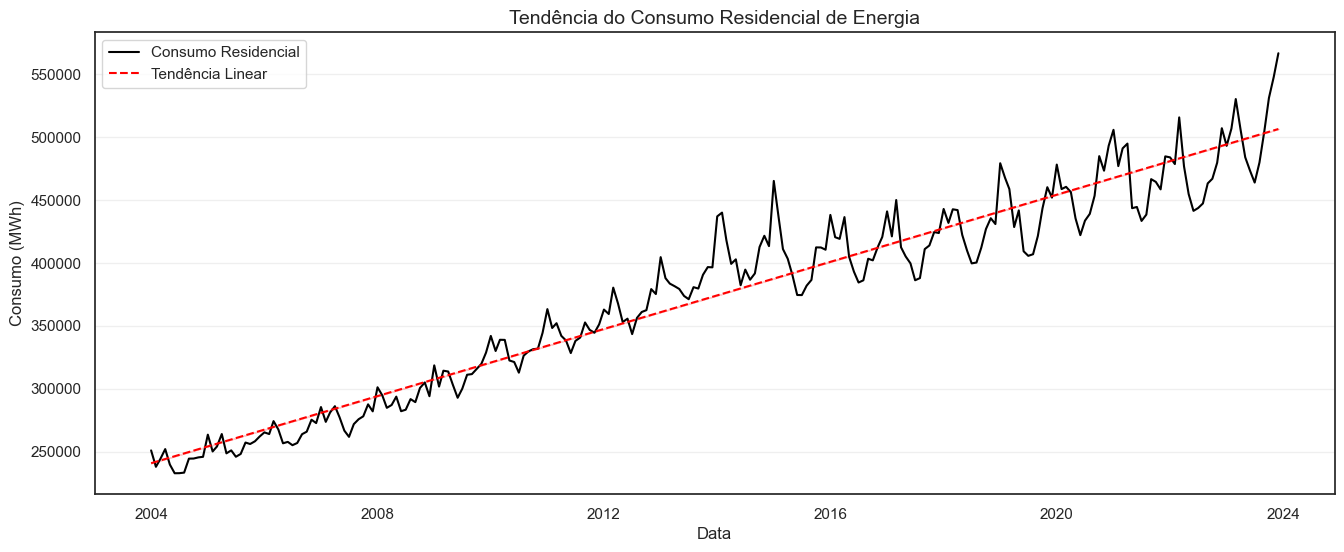

In [248]:
X_residencial = data_consumo_energia['data'].map(lambda d: d.timestamp()).values.reshape(-1, 1)
y_residencial = data_consumo_energia['consumo_residencial']

modelo_comercial = LinearRegression().fit(X_residencial, y_residencial)
data_consumo_energia['tendencia_residencial'] = modelo_comercial.predict(X_residencial)


plt.figure(figsize=(16, 6))
sns.lineplot(data=data_consumo_energia, x='data', y='consumo_residencial', label='Consumo Residencial', color='black', errorbar=None)
#sns.lineplot(data=data_consumo_energia, x='data', y='numero_consumidores_residencial', label='Número de Consumidores', color='green', errorbar=None)
sns.lineplot(data=data_consumo_energia, x='data', y='tendencia_residencial', label='Tendência Linear', color='red', linestyle='--')

plt.title('Tendência do Consumo Residencial de Energia', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Consumo (MWh)', fontsize=12)

plt.legend()
plt.grid(axis='y', alpha=0.3)


> Entre 2004 e 2023, observa-se uma forte tendência de crescimento linear no consumo de energia residencial, acompanhada por um aumento significativo no número de consumidores. A variação periódica ao longo da linha  de consumo reflete a sazonalidade, influenciada por fatores como meses do ano e estações, indicando padrões consistentes de maior e menor demanda energética em diferentes períodos anuais.
---

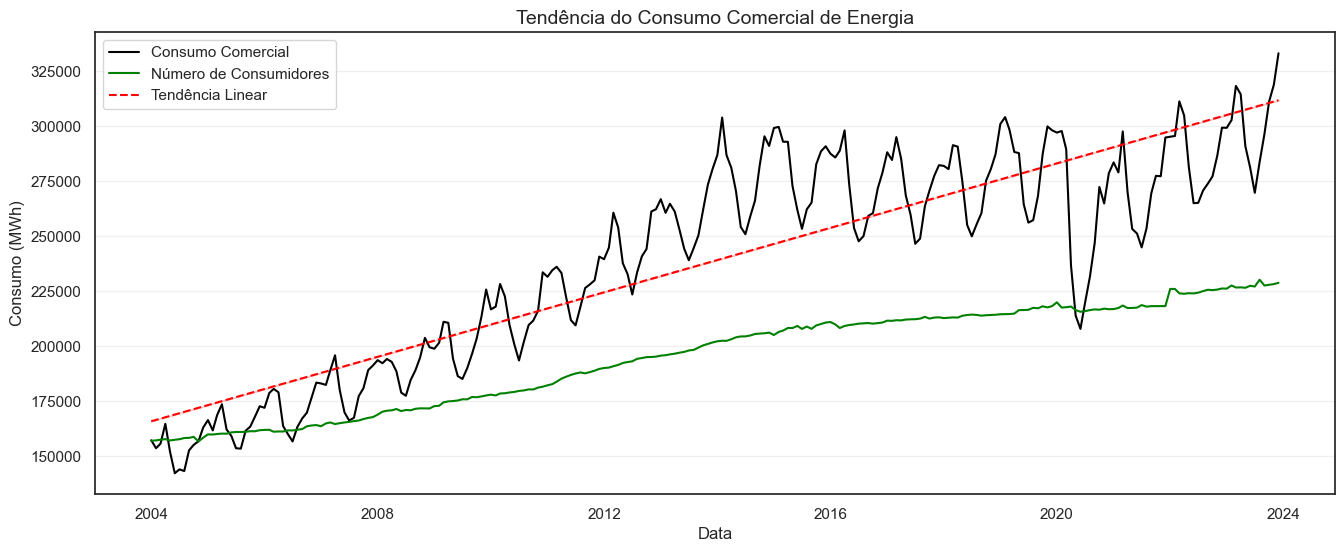

In [249]:
X_comercial = data_consumo_energia['data'].map(lambda d: d.timestamp()).values.reshape(-1, 1)
y_comercial = data_consumo_energia['consumo_comercial']

modelo_comercial = LinearRegression().fit(X_comercial, y_comercial)
data_consumo_energia['tendencia_comercial'] = modelo_comercial.predict(X_comercial)


plt.figure(figsize=(16, 6))
sns.lineplot(data=data_consumo_energia, x='data', y='consumo_comercial', label='Consumo Comercial', color='black', errorbar=None)
sns.lineplot(data=data_consumo_energia, x='data', y='numero_consumidores_comercial', label='Número de Consumidores', color='green', errorbar=None)
sns.lineplot(data=data_consumo_energia, x='data', y='tendencia_comercial', label='Tendência Linear', color='red', linestyle='--')

plt.title('Tendência do Consumo Comercial de Energia', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Consumo (MWh)', fontsize=12)

plt.legend()
plt.grid(axis='y', alpha=0.3)


>De 2004 a 2023, o consumo comercial de energia apresenta uma forte variação sazonal, ainda mais acentuada do que no setor residencial, refletindo a influência de períodos específicos do ano sobre a demanda. Em 2020, há uma queda significativa no consumo, provavelmente devido aos impactos da pandemia de Covid-19. A quantidade de consumidores comerciais mostra uma tendência linear de crescimento até 2016, quando o ritmo desacelera e passa a se estabilizar ou lateralizar nos anos subsequentes.
---

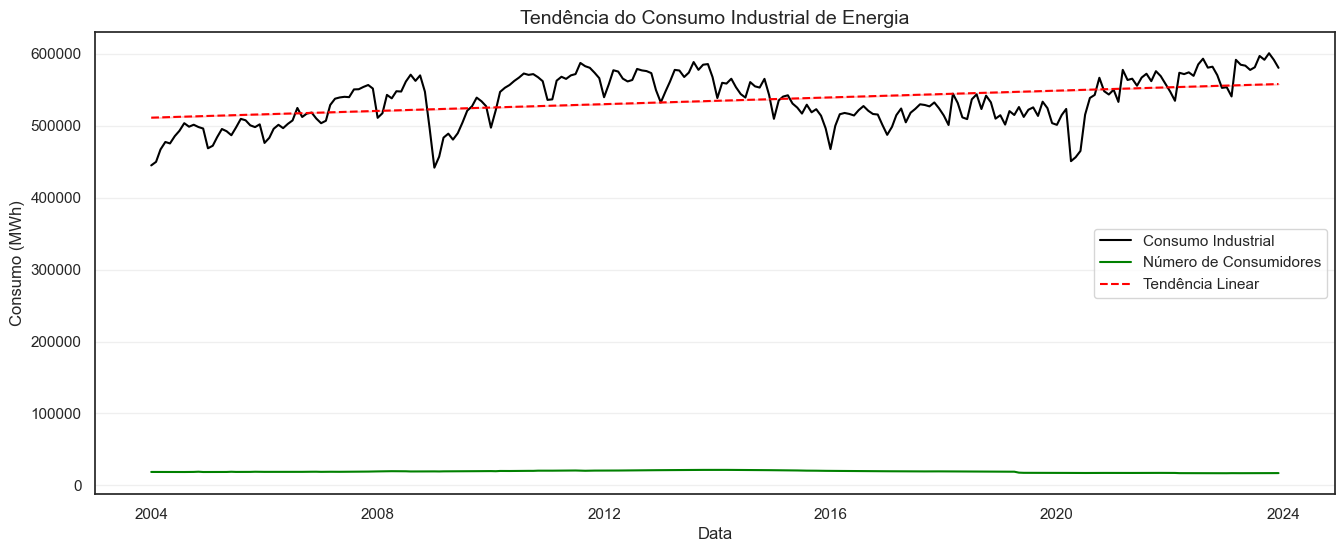

In [250]:
X_industrial = data_consumo_energia['data'].map(lambda d: d.timestamp()).values.reshape(-1, 1)
y_industrial = data_consumo_energia['consumo_industrial']

modelo_comercial = LinearRegression().fit(X_industrial, y_industrial)
data_consumo_energia['tendencia_industrial'] = modelo_comercial.predict(X_industrial)


plt.figure(figsize=(16, 6))
sns.lineplot(data=data_consumo_energia, x='data', y='consumo_industrial', label='Consumo Industrial', color='black', errorbar=None)
sns.lineplot(data=data_consumo_energia, x='data', y='numero_consumidores_industrial', label='Número de Consumidores', color='green', errorbar=None)
sns.lineplot(data=data_consumo_energia, x='data', y='tendencia_industrial', label='Tendência Linear', color='red', linestyle='--')

plt.title('Tendência do Consumo Industrial de Energia', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Consumo (MWh)', fontsize=12)

plt.legend()
plt.grid(axis='y', alpha=0.3)

>Nos dados do setor industrial, é possível perceber um aumento significativo no consumo de energia em um intervalo de 8 anos, acompanhado por uma leve tendência de crescimento ao longo do tempo, como indica a linha de tendência linear. No entanto, a quantidade de consumidores industriais permanece praticamente constante durante todo o período de 2004 a 2023, sem apresentar variações relevantes.
---

In [251]:
data_consumo_energia.head()

,ano,mes,sigla_uf,numero_consumidores_outros,consumo_outros,numero_consumidores_residencial,consumo_residencial,numero_consumidores_comercial,consumo_comercial,numero_consumidores_industrial,consumo_industrial,total_consumidores,total_consumo,data,tendencia_residencial,tendencia_comercial,tendencia_industrial
0,2004,1,AC,9943.0,9428,103396.0,15778,12175.0,7895,761.0,1738,126275.0,34839,2004-01-01,240973.105237,165851.369282,511135.982402
1,2004,1,AL,14543.0,48286,577321.0,59273,42568.0,31461,2584.0,146469,637016.0,285489,2004-01-01,240973.105237,165851.369282,511135.982402
2,2004,1,AM,10118.0,47019,480619.0,84473,49055.0,49832,3363.0,93449,543155.0,274773,2004-01-01,240973.105237,165851.369282,511135.982402
3,2004,1,AP,2184.0,5939,102074.0,21780,9264.0,12164,579.0,3201,114101.0,43084,2004-01-01,240973.105237,165851.369282,511135.982402
4,2004,1,BA,212682.0,215666,3011623.0,294797,259528.0,171569,18433.0,762417,3502266.0,1444449,2004-01-01,240973.105237,165851.369282,511135.982402


In [252]:
data_consumo_energia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6480 entries, 0 to 6479
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   ano                              6480 non-null   int64         
 1   mes                              6480 non-null   int64         
 2   sigla_uf                         6480 non-null   object        
 3   numero_consumidores_outros       6480 non-null   float64       
 4   consumo_outros                   6480 non-null   int64         
 5   numero_consumidores_residencial  6480 non-null   float64       
 6   consumo_residencial              6480 non-null   int64         
 7   numero_consumidores_comercial    6480 non-null   float64       
 8   consumo_comercial                6480 non-null   int64         
 9   numero_consumidores_industrial   6480 non-null   float64       
 10  consumo_industrial               6480 non-null   int64      

In [253]:
data_consumo_energia.to_csv('consumo_energia_eletrica_uf_final.csv', sep=',', index=False)